# 3. Создание нейронной сети при помощи пакета `torch`. Dataset и Dataloader.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г. 

In [75]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Автоматическое дифференцирование в `torch`

1.1 Воспользовавшись классами `Neuron` и `MSELoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [76]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [77]:
def pretty_train_log(epoch: int, **kwargs) -> None:
    params = '\n\t'.join([f'{k} = {v}' for k, v in kwargs.items()])
    print(f'epoch {epoch:03} |' + '-' * 50 + f'\n\t{params}\n')

In [78]:
class Neuron:

    def __init__(self, in_features: int):
        self.in_features = in_features

        self.weights = torch.randn(self.in_features, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.sum(self.weights * inputs) + self.bias


class SELoss:

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return (y_pred - y_true) ** 2


In [79]:
torch.manual_seed(0)

neuron = Neuron(X.size(1))
se = SELoss()

lr = 0.1
optimizer = torch.optim.SGD([neuron.weights, neuron.bias], lr=lr)
epochs = 10

for epoch in range(epochs + 1):
    for i, (x, y_true) in enumerate(zip(X, y)):
        y_pred = neuron.forward(x)
        loss = se.forward(y_pred, y_true)

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and i % 50 == 0:
            pretty_train_log(
                epoch,
                i=i,
                weights=neuron.weights,
                dw=neuron.weights.grad,
                bias=neuron.bias,
                db=neuron.bias.grad,
                loss=loss,
            )

        optimizer.zero_grad()

neuron.weights, coef

epoch 000 |--------------------------------------------------
	i = 0
	weights = tensor([ 2.3885, -0.6152,  0.9567,  0.4048], requires_grad=True)
	dw = tensor([ -8.4751,   3.2173, -31.3549,   1.6363])
	bias = tensor([2.4158], requires_grad=True)
	db = tensor([-35.0033])
	loss = tensor([306.3077], grad_fn=<PowBackward0>)

epoch 000 |--------------------------------------------------
	i = 50
	weights = tensor([68.9588,  2.2578,  1.2310, 76.4627], requires_grad=True)
	dw = tensor([ 1.1491, -3.6380, -0.0116,  1.4666])
	bias = tensor([0.5364], requires_grad=True)
	db = tensor([2.6421])
	loss = tensor([1.7451], grad_fn=<PowBackward0>)

epoch 005 |--------------------------------------------------
	i = 0
	weights = tensor([69.2648,  2.6558,  1.5509, 76.5135], requires_grad=True)
	dw = tensor([ 4.1563e-06, -1.5778e-06,  1.5377e-05, -8.0247e-07])
	bias = tensor([0.5000], requires_grad=True)
	db = tensor([1.7166e-05])
	loss = tensor([7.3669e-11], grad_fn=<PowBackward0>)

epoch 005 |--------------

(tensor([69.2648,  2.6558,  1.5509, 76.5134], requires_grad=True),
 array([69.26485673,  2.65577295,  1.55092277, 76.51344004]))

1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [80]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [81]:
class Linear:

    def __init__(self, in_features: int, out_features: int):
        self.in_features = in_features
        self.out_features = out_features

        self.weights = torch.randn(out_features, in_features, requires_grad=True)
        self.biases = torch.randn(out_features, requires_grad=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.matmul(inputs, self.weights.T) + self.biases


class MSELoss:

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return torch.mean((y_pred - y_true) ** 2)


In [82]:
torch.manual_seed(0)

layer = Linear(X.size(1), y.size(1))
mse = MSELoss()

lr = 0.1
optimizer = torch.optim.SGD([layer.weights, layer.biases], lr=lr)
epochs = 500

losses = torch.empty(epochs + 1)
for epoch in range(epochs + 1):
    y_pred = layer.forward(X)

    loss = mse.forward(y_pred, y)
    losses[epoch] = loss
    loss.backward()

    optimizer.step()

    if epoch % 100 == 0:
        pretty_train_log(
            epoch,
            weights=layer.weights,
            dw=layer.weights.grad,
            bias=layer.biases,
            db=layer.biases.grad,
            loss=loss,
        )

    optimizer.zero_grad()

predicts = layer.forward(X)

epoch 000 |--------------------------------------------------
	weights = tensor([[1.4405]], requires_grad=True)
	dw = tensor([[1.0053]])
	bias = tensor([-0.3791], requires_grad=True)
	db = tensor([0.8570])
	loss = 1.3648285865783691

epoch 100 |--------------------------------------------------
	weights = tensor([[-1.0424]], requires_grad=True)
	dw = tensor([[0.1100]])
	bias = tensor([0.5407], requires_grad=True)
	db = tensor([-0.0589])
	loss = 0.2608502209186554

epoch 200 |--------------------------------------------------
	weights = tensor([[-1.6416]], requires_grad=True)
	dw = tensor([[0.0285]])
	bias = tensor([0.8618], requires_grad=True)
	db = tensor([-0.0153])
	loss = 0.2067205011844635

epoch 300 |--------------------------------------------------
	weights = tensor([[-1.7970]], requires_grad=True)
	dw = tensor([[0.0074]])
	bias = tensor([0.9451], requires_grad=True)
	db = tensor([-0.0040])
	loss = 0.2030831277370453

epoch 400 |--------------------------------------------------

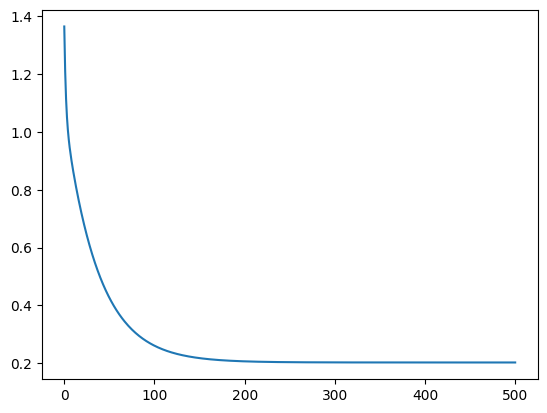

In [86]:
plt.plot(range(losses.size(0)), losses.detach().numpy());

In [84]:
sns.plot(predicts, y)

## 2. Алгоритмы оптимизации в `torch.optim`

2.1 Решить задачу 1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

2.2 Решить задачу 1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

## 3. Построение сетей при помощи `torch.nn`

3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

3.3 Решить задачу классификации. Датасет: Breast Cancer Wisconsin
1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

## 4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset

4.1 Создать датасет, поставляющий данные из задачи 1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.1 (или 3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [2]:
class SinDataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

4.2 Предсказание цен алмазов

4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

4.3 Модифицируйте метод `__init__` датасета из 4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        # ....
        self.transform = transform
        # ....

    def __len__(self):
        pass

    def __getitem__(self, idx):
        # ...
        sample = self.X[idx], self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        # ....

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        pass

    def __call__(self, sample):
        X, y = sample
        # <удаление из X столбцов self.drop>
        return X, y

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        X, y = sample
        # <преобразование X и y в тензоры>
        return X, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(data, transforms.compose([drop, to_tensor]))
